# `N-Queens Problem: Simulated Annealing and Genetic Algorithm`
### Artificial Intelligence  
#### Omid Naeej Nejad - 610301189
Fall 2025

---

## Project Information

This notebook implements the practical part of the AI assignment. The generalized N-Queens problem allows placing `m` queens on an `N × N` board where `1 ≤ m ≤ N²`. Two optimization techniques are used:

1. **Simulated Annealing (SA)**  
2. **Genetic Algorithm (GA)**  

The final sections compare the algorithms in terms of speed, stability, and scalability.

---

## Contents

1. **Generalized N-Queens Modeling**  
2. **Simulated Annealing Implementation**  
3. **Genetic Algorithm Implementation**  
4. **Experiments & Visualizations**  
5. **Comparison and Discussion**  
6. **Conclusion**


## Import dependencies

In [3]:
from __future__ import annotations

import math
import random
import time
from dataclasses import dataclass
from typing import List, Tuple, Dict, Any, Optional
import numpy as np
import matplotlib.pyplot as plt


## Core N-Queens problem (state, energy, board drawing)

We represent a state as a vector of length m (number of queens).
Index i = column, value state[i] = row of the queen in that column.
We embed these m columns into an N×N board (leftmost m columns).

Each state is represented as:

positions = (p₁, p₂, …, pₘ)

where each pᵢ is an integer in [0, N²−1], mapping to board coordinates via:

row = p // N
col = p % N


### **Energy Function**

The evaluation function (energy) is defined as:

Energy = number of attacking pairs of queens

Two queens at (r₁, c₁) and (r₂, c₂) attack if:

* r₁ = r₂  (same row)
* c₁ = c₂  (same column)
* |r₁ − r₂| = |c₁ − c₂|  (same diagonal)

The goal is to reach **Energy = 0**, i.e., a configuration with **no conflicts**.

In [4]:
@dataclass(frozen=True)
class NQueensState:
    """
    Generalized N-Queens state:
    positions[i] is a flattened index in [0, N^2 - 1] for queen i.
    All positions are distinct.
    """
    positions: Tuple[int, ...]


class NQueensProblem:
    """
    Generalized N-Queens:
    - Board: N x N
    - m queens, 1 <= m <= N^2
    - A state is a set of m distinct squares.
    - Energy = number of attacking pairs (row, column, or diagonal).
    """

    def __init__(self, board_size: int, num_queens: Optional[int] = None, seed: Optional[int] = None):
        if num_queens is None:
            num_queens = board_size

        if num_queens <= 0 or num_queens > board_size * board_size:
            raise ValueError("num_queens must be in 1..N^2")

        self.N = board_size
        self.m = num_queens
        self.random = random.Random(seed)

    # ---------- helpers ----------

    def _pos_to_rc(self, pos: int) -> Tuple[int, int]:
        """
        Convert flattened position to (row, col).
        """
        return divmod(pos, self.N)

    # ---------- state / energy ----------

    def random_state(self) -> NQueensState:
        """
        Random state: m distinct positions on the board.
        """
        all_positions = list(range(self.N * self.N))
        positions = tuple(self.random.sample(all_positions, self.m))
        return NQueensState(positions=positions)

    @staticmethod
    def count_conflicts_for_positions(
        positions: Tuple[int, ...],
        board_size: int,
    ) -> int:
        """
        Number of attacking pairs of queens on an N x N board.
        positions are flattened indices.
        """
        conflicts = 0
        m = len(positions)
        for i in range(m):
            r1, c1 = divmod(positions[i], board_size)
            for j in range(i + 1, m):
                r2, c2 = divmod(positions[j], board_size)
                # same row
                if r1 == r2:
                    conflicts += 1
                # same column
                if c1 == c2:
                    conflicts += 1
                # same diagonal
                if abs(r1 - r2) == abs(c1 - c2):
                    conflicts += 1
        return conflicts

    def count_conflicts(self, state: NQueensState) -> int:
        return self.count_conflicts_for_positions(state.positions, self.N)

    def energy(self, state: NQueensState) -> int:
        """
        Energy = number of attacking pairs. 0 means a valid configuration.
        """
        return self.count_conflicts(state)

    def is_goal(self, state: NQueensState) -> bool:
        return self.energy(state) == 0

    # ---------- visualization ----------

    def plot_board(self, state: NQueensState, title: str = "N-Queens configuration"):
        """
        Visualize the board with queens on the given positions.
        """
        board = [[0 for _ in range(self.N)] for _ in range(self.N)]
        for pos in state.positions:
            r, c = divmod(pos, self.N)
            board[r][c] = 1

        fig, ax = plt.subplots(figsize=(5, 5))
        ax.imshow(board, origin="upper")
        ax.set_xticks(range(self.N))
        ax.set_yticks(range(self.N))
        ax.set_xticklabels(range(self.N))
        ax.set_yticklabels(range(self.N))
        ax.set_title(title)
        ax.grid(True, which="both")
        plt.show()

    def pretty_print(self, state: NQueensState):
        """
        Print board in text mode (for terminal).
        """
        board = [["." for _ in range(self.N)] for _ in range(self.N)]
        for pos in state.positions:
            r, c = divmod(pos, self.N)
            board[r][c] = "Q"
        for r in range(self.N):
            print(" ".join(board[r]))


## Simulated Annealing (SA)

We implement:
state definition, energy, initial state, neighbor function, acceptance criterion, temperature schedule, stopping, logging, reheating, and final visualization hooks.

### 2.1 Initial State

An initial random configuration is generated by sampling m **distinct** squares from the N² available squares.

### 2.2 Neighbor Function

The neighbor function randomly:

1. selects one queen
2. moves it to a new *free* board square

Important constraints:

* the new square must not already contain another queen
* the new square must be different from the current position

### 2.3 Acceptance Criterion (Metropolis Rule)

Given:

* Eₜ = current energy
* Eₙ = new energy
* T = temperature

We accept the new state with probability:

If Eₙ ≤ Eₜ
 accept
Else
 accept with probability p = exp(−(Eₙ − Eₜ)/T)

Reason:

* Allows accepting worse solutions at high T (exploration)
* Biases toward better solutions as T decreases (exploitation)

This is essential for escaping local minima.

### 2.4 Temperature Schedule

A multiplicative cooling schedule is used:

T ← αT
with α typically in [0.95, 0.9995]

At each temperature level, we perform a fixed number of iterations (`iterations_per_temp`). This combination is standard practice in SA literature and works reliably for constraint satisfaction problems.

### 2.5 Reheating Strategy

We detect stagnation when:

(iteration − last_improvement_iteration) ≥ stagnation_window

Then temperature is increased:

T ← T × reheating_factor

Motivation:

* Reheating prevents the algorithm from prematurely converging to a local optimum.
* It reintroduces exploration capability.

### 2.6 Stopping Conditions

The algorithm stops when:

* best_energy = 0 (solution found), OR
* max_iterations is reached

### 2.7 Logging

During the search, we store:

* energy at each iteration
* best energy so far
* temperature
* running time


In [5]:
class SimulatedAnnealingSolver:
    """
    Simulated Annealing for generalized N-Queens (m up to N^2).
    """

    def __init__(
        self,
        problem: NQueensProblem,
        T0: float = 10.0,
        alpha: float = 0.99,
        max_iterations: int = 50_000,
        iterations_per_temp: int = 50,
        reheating_factor: float = 1.5,
        stagnation_window: int = 1_000,
        seed: Optional[int] = None,
    ):
        self.problem = problem
        self.T0 = T0
        self.alpha = alpha
        self.max_iterations = max_iterations
        self.iterations_per_temp = iterations_per_temp
        self.reheating_factor = reheating_factor
        self.stagnation_window = stagnation_window
        self.random = random.Random(seed)

    # ---------- neighbor ----------

    def _neighbor(self, state: NQueensState) -> NQueensState:
        """
        Move one queen to another empty square (keep positions distinct).
        """
        N2 = self.problem.N * self.problem.N
        positions = list(state.positions)
        m = len(positions)

        # choose a queen to move
        idx = self.random.randrange(m)
        current_pos = positions[idx]

        taken = set(positions)
        taken.remove(current_pos)

        # possible new positions = all squares not taken
        candidates = [p for p in range(N2) if p not in taken]
        # ensure we actually change the position
        candidates = [p for p in candidates if p != current_pos]
        new_pos = self.random.choice(candidates)

        positions[idx] = new_pos
        return NQueensState(positions=tuple(positions))

    # ---------- acceptance ----------

    def _accept(self, current_energy: int, new_energy: int, temperature: float) -> bool:
        if new_energy <= current_energy:
            return True
        if temperature <= 0:
            return False
        delta = new_energy - current_energy
        prob = math.exp(-delta / temperature)
        return self.random.random() < prob

    # ---------- main loop ----------

    def solve(self, initial_state: Optional[NQueensState] = None) -> Dict[str, Any]:
        problem = self.problem
        if initial_state is None:
            current = problem.random_state()
        else:
            current = initial_state

        current_energy = problem.energy(current)
        best_state = current
        best_energy = current_energy

        T = self.T0
        iteration = 0
        last_improvement_iter = 0

        history_energy: List[int] = []
        history_best_energy: List[int] = []
        history_temperature: List[float] = []
        history_time: List[float] = []

        start_time = time.perf_counter()

        while iteration < self.max_iterations and best_energy > 0:
            for _ in range(self.iterations_per_temp):
                iteration += 1
                if iteration > self.max_iterations:
                    break

                new_state = self._neighbor(current)
                new_energy = problem.energy(new_state)

                if self._accept(current_energy, new_energy, T):
                    current, current_energy = new_state, new_energy

                if current_energy < best_energy:
                    best_state, best_energy = current, current_energy
                    last_improvement_iter = iteration

                # log
                history_energy.append(current_energy)
                history_best_energy.append(best_energy)
                history_temperature.append(T)
                history_time.append(time.perf_counter() - start_time)

                # stagnation + reheating
                if self.stagnation_window is not None:
                    if iteration - last_improvement_iter >= self.stagnation_window:
                        T *= self.reheating_factor
                        last_improvement_iter = iteration

                if best_energy == 0:
                    break

            # cooling
            T *= self.alpha

        elapsed = time.perf_counter() - start_time

        return {
            "best_state": best_state,
            "best_energy": best_energy,
            "history": {
                "energy": history_energy,
                "best_energy": history_best_energy,
                "temperature": history_temperature,
                "time": history_time,
            },
            "elapsed_time": elapsed,
        }

    # ---------- plotting ----------

    @staticmethod
    def plot_history(history: Dict[str, List[float]]):
        energies = history["energy"]
        best_energies = history["best_energy"]

        plt.figure(figsize=(7, 4))
        plt.plot(energies, label="Energy")
        plt.plot(best_energies, label="Best energy so far")
        plt.xlabel("Iteration")
        plt.ylabel("Energy (number of conflicts)")
        plt.title("Simulated Annealing energy history")
        plt.legend()
        plt.grid(True)
        plt.show()


## Genetic Algorithm (GA)

Chromosome = same as state: vector of length m, each gene is row index for column i.
We define fitness based on number of non-attacking pairs.

### 3.1 Chromosome Representation

A chromosome is:

chrom = [p₁, p₂, …, pₘ]

where each pᵢ is a unique board position in [0, N²−1].

This representation naturally accommodates any m ≤ N².

### 3.2 Initial Population

The initial population is generated by random sampling of m distinct board squares.

Population size is typically 100–500 depending on N.

### 3.3 Fitness Function

Fitness is defined as:

Fitness = TotalNonAttackingPairs
= max_pairs − energy

where:
max_pairs = m(m−1)/2

Thus:

* Higher fitness means fewer conflicts
* Maximum fitness corresponds to goal state


### 3.4 Selection Mechanism — Tournament Selection

Tournament selection with size k (typically 2–4):

1. Randomly pick k individuals
2. Select the one with highest fitness

Advantages:

* Balances selective pressure
* Computationally efficient
* Simple to implement

### 3.5 Crossover Operator — Single-Point Crossover

Two parents undergo single-point crossover:

child1 = parent1[:p] + parent2[p:]
child2 = parent2[:p] + parent1[p:]

Pros:

* Preserves large blocks of spatial structure (useful in N-Queens)
* Simple and fast

### 3.6 Mutation Operator

Each gene may be mutated with probability `mutation_rate`:

chrom[i] ← random position (0 … N²−1)

This introduces randomness and diversity into the population.

### 3.7 Repair Operator (Distinctness Enforcement)

Because crossover or mutation can introduce duplicates, a **repair step** is required:

* Detect duplicates
* Replace them with unused positions

This maintains the validity of chromosomes and ensures that GA explores only feasible states.

### 3.8 Elitism

If enabled, the best chromosome of each generation is automatically copied into the next generation.

Purpose:

* Prevents loss of the best solutions
* Encourages monotonic improvement across generations

### 3.9 Stopping Conditions

The GA terminates when:

* best_fitness reaches max_pairs (solution found), OR
* max_generations reached



In [6]:
class GeneticAlgorithmSolver:
    """
    Genetic Algorithm for generalized N-Queens:
    - Chromosome: list of m distinct positions in [0, N^2 - 1].
    """

    def __init__(
        self,
        problem: NQueensProblem,
        population_size: int = 200,
        crossover_rate: float = 0.9,
        mutation_rate: float = 0.2,
        max_generations: int = 1_000,
        tournament_size: int = 3,
        elitism: bool = True,
        seed: Optional[int] = None,
    ):
        self.problem = problem
        self.population_size = population_size
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.max_generations = max_generations
        self.tournament_size = tournament_size
        self.elitism = elitism
        self.random = random.Random(seed)

        # max number of non-attacking pairs (for fitness scaling)
        self.max_pairs = problem.m * (problem.m - 1) // 2

    # ---------- representation ----------

    def _random_chromosome(self) -> List[int]:
        """
        Random chromosome with m distinct positions.
        """
        N2 = self.problem.N * self.problem.N
        return self.random.sample(range(N2), self.problem.m)

    def _chromosome_to_state(self, chrom: List[int]) -> NQueensState:
        return NQueensState(positions=tuple(chrom))

    # ---------- repair to ensure distinct positions ----------

    def _repair(self, chrom: List[int]) -> None:
        """
        Ensure all positions in chrom are distinct.
        If duplicates exist, replace them with unused positions.
        """
        N2 = self.problem.N * self.problem.N
        all_positions = set(range(N2))

        seen = set()
        for i, pos in enumerate(chrom):
            if pos not in seen:
                seen.add(pos)
            else:
                # duplicate -> choose a new unused position
                unused = list(all_positions - seen)
                if not unused:
                    # fully packed, nothing to do
                    break
                new_pos = self.random.choice(unused)
                chrom[i] = new_pos
                seen.add(new_pos)

    # ---------- fitness ----------

    def _fitness(self, chrom: List[int]) -> float:
        """
        Fitness = number of non-attacking pairs.
        Maximum when there are no conflicts.
        """
        state = self._chromosome_to_state(chrom)
        conflicts = self.problem.energy(state)
        return float(self.max_pairs - conflicts)

    # ---------- selection (tournament) ----------

    def _tournament_select(self, population: List[List[int]], fitnesses: List[float]) -> List[int]:
        indices = [self.random.randrange(len(population)) for _ in range(self.tournament_size)]
        best_idx = max(indices, key=lambda idx: fitnesses[idx])
        return population[best_idx][:]

    # ---------- crossover ----------

    def _crossover(self, p1: List[int], p2: List[int]) -> Tuple[List[int], List[int]]:
        if self.random.random() > self.crossover_rate or len(p1) <= 1:
            return p1[:], p2[:]

        m = len(p1)
        point = self.random.randint(1, m - 1)
        c1 = p1[:point] + p2[point:]
        c2 = p2[:point] + p1[point:]
        return c1, c2

    # ---------- mutation ----------

    def _mutate(self, chrom: List[int]) -> None:
        N2 = self.problem.N * self.problem.N
        for i in range(len(chrom)):
            if self.random.random() < self.mutation_rate:
                chrom[i] = self.random.randrange(N2)

    # ---------- main GA loop ----------

    def solve(self) -> Dict[str, Any]:
        # initial population
        population = [self._random_chromosome() for _ in range(self.population_size)]
        for chrom in population:
            self._repair(chrom)

        fitnesses = [self._fitness(ch) for ch in population]

        best_idx = max(range(self.population_size), key=lambda i: fitnesses[i])
        best_chrom = population[best_idx][:]
        best_fitness = fitnesses[best_idx]

        history_best: List[float] = []
        history_mean: List[float] = []

        start_time = time.perf_counter()

        for gen in range(self.max_generations):
            # log
            history_best.append(best_fitness)
            history_mean.append(sum(fitnesses) / len(fitnesses))

            if best_fitness == float(self.max_pairs):
                break

            new_population: List[List[int]] = []

            # elitism
            if self.elitism:
                new_population.append(best_chrom[:])

            # create rest
            while len(new_population) < self.population_size:
                p1 = self._tournament_select(population, fitnesses)
                p2 = self._tournament_select(population, fitnesses)
                c1, c2 = self._crossover(p1, p2)
                self._mutate(c1)
                self._mutate(c2)
                self._repair(c1)
                self._repair(c2)
                new_population.append(c1)
                if len(new_population) < self.population_size:
                    new_population.append(c2)

            population = new_population
            fitnesses = [self._fitness(ch) for ch in population]

            best_idx = max(range(self.population_size), key=lambda i: fitnesses[i])
            current_best = fitnesses[best_idx]
            if current_best > best_fitness:
                best_fitness = current_best
                best_chrom = population[best_idx][:]

        elapsed = time.perf_counter() - start_time
        best_state = self._chromosome_to_state(best_chrom)
        best_energy = self.problem.energy(best_state)

        return {
            "best_state": best_state,
            "best_fitness": best_fitness,
            "best_energy": best_energy,
            "history": {
                "best_fitness": history_best,
                "mean_fitness": history_mean,
            },
            "elapsed_time": elapsed,
        }

    # ---------- plotting ----------

    @staticmethod
    def plot_history(history: Dict[str, List[float]]):
        best = history["best_fitness"]
        mean = history["mean_fitness"]

        plt.figure(figsize=(7, 4))
        plt.plot(best, label="Best fitness")
        plt.plot(mean, label="Mean fitness")
        plt.xlabel("Generation")
        plt.ylabel("Fitness (non-attacking pairs)")
        plt.title("Genetic Algorithm fitness history")
        plt.legend()
        plt.grid(True)
        plt.show()


## Helper: run and compare SA vs GA

This cell gives you a convenient entry point for experiments and visualizations.


In [7]:
def run_simulated_annealing_example(
    N: int = 20,
    m: Optional[int] = None,
    seed: int = 0,
) -> Dict[str, Any]:
    """
    Run SA once and visualize history and final board.
    """
    problem = NQueensProblem(board_size=N, num_queens=m, seed=seed)
    sa = SimulatedAnnealingSolver(
        problem,
        T0=10.0,
        alpha=0.995,
        max_iterations=50_000,
        iterations_per_temp=50,
        reheating_factor=1.5,
        stagnation_window=1_000,
        seed=seed,
    )
    result = sa.solve()
    print("Simulated Annealing:")
    print(f"  Board size: {problem.N}x{problem.N}, queens: {problem.m}")
    print(f"  Best energy (conflicts): {result['best_energy']}")
    print(f"  Elapsed time: {result['elapsed_time']:.4f} seconds")

    problem.pretty_print(result["best_state"])
    problem.plot_board(result["best_state"], title="SA solution")

    SimulatedAnnealingSolver.plot_history(result["history"])
    return result


def run_genetic_algorithm_example(
    N: int = 20,
    m: Optional[int] = None,
    seed: int = 0,
) -> Dict[str, Any]:
    """
    Run GA once and visualize history and final board.
    """
    problem = NQueensProblem(board_size=N, num_queens=m, seed=seed)
    ga = GeneticAlgorithmSolver(
        problem,
        population_size=200,
        crossover_rate=0.9,
        mutation_rate=0.2,
        max_generations=2_000,
        tournament_size=3,
        elitism=True,
        seed=seed,
    )
    result = ga.solve()
    print("Genetic Algorithm:")
    print(f"  Board size: {problem.N}x{problem.N}, queens: {problem.m}")
    print(f"  Best energy (conflicts): {result['best_energy']}")
    print(f"  Best fitness: {result['best_fitness']:.0f}")
    print(f"  Elapsed time: {result['elapsed_time']:.4f} seconds")

    problem.pretty_print(result["best_state"])
    problem.plot_board(result["best_state"], title="GA solution")

    GeneticAlgorithmSolver.plot_history(result["history"])
    return result


def compare_sa_and_ga(
    N: int = 20,
    m: Optional[int] = None,
    seed_sa: int = 0,
    seed_ga: int = 1,
) -> Dict[str, Dict[str, Any]]:
    """
    Run both SA and GA on the same problem and print a simple comparison.
    """
    if m is None:
        m = N

    print("=== Running Simulated Annealing ===")
    sa_res = run_simulated_annealing_example(N=N, m=m, seed=seed_sa)

    print("\n=== Running Genetic Algorithm ===")
    ga_res = run_genetic_algorithm_example(N=N, m=m, seed=seed_ga)

    print("\n=== Comparison (single run) ===")
    print(f"SA: best_energy={sa_res['best_energy']}, time={sa_res['elapsed_time']:.4f}s")
    print(f"GA: best_energy={ga_res['best_energy']}, time={ga_res['elapsed_time']:.4f}s")

    return {"SA": sa_res, "GA": ga_res}


### Run Examples

#### Classic 8-Queens with both algorithms


=== Running Simulated Annealing ===
Simulated Annealing:
  Board size: 8x8, queens: 8
  Best energy (conflicts): 2
  Elapsed time: 0.8198 seconds
Q . . . . . . .
. . . . Q . . .
. . . . . . Q .
. . . . . . . .
. . . Q . . . .
. Q . . . . . .
. . . . . . . Q
. . . . Q Q . .


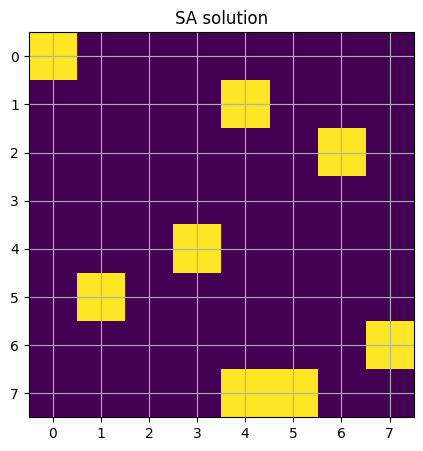

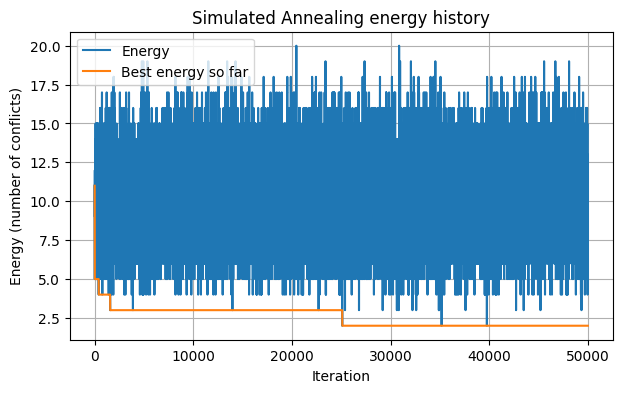


=== Running Genetic Algorithm ===
Genetic Algorithm:
  Board size: 8x8, queens: 8
  Best energy (conflicts): 1
  Best fitness: 27
  Elapsed time: 8.5509 seconds
. . . Q . . . .
. Q . . . . . .
. . . . . . . Q
. . . . . Q . .
. Q . . . . . .
. . . . . . Q .
. . . . Q . . .
Q . . . . . . .


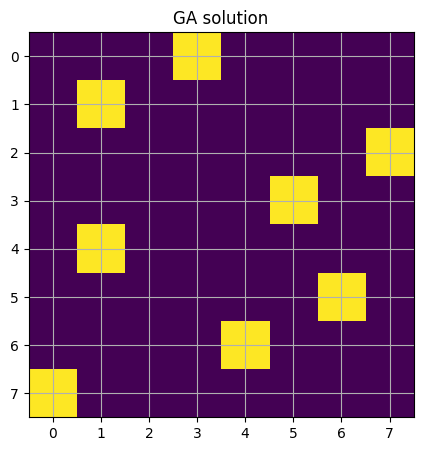

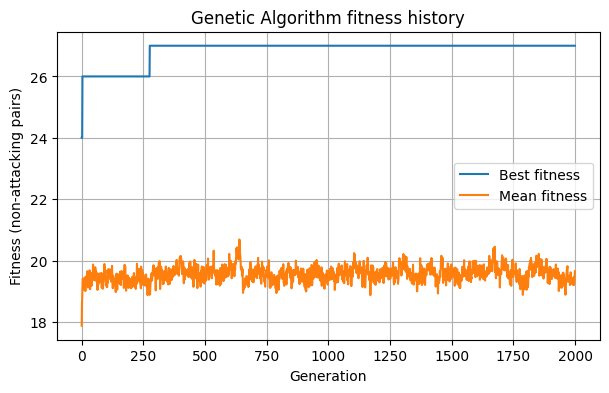


=== Comparison (single run) ===
SA: best_energy=2, time=0.8198s
GA: best_energy=1, time=8.5509s


In [9]:
compare_results_8 = compare_sa_and_ga(N=8, m=8, seed_sa=0, seed_ga=1)

=== Running Simulated Annealing ===
Simulated Annealing:
  Board size: 20x20, queens: 20
  Best energy (conflicts): 14
  Elapsed time: 5.2909 seconds
. . . . . . . . . . . . . . . Q . . . .
. . . . . . . . . . . . Q . . . . . . .
Q . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . Q
. . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .
. . Q . . . Q . . . . . . . . . . . . .
. . . . . . . . . . . . . Q . . . . . .
. . . . . . . . . . . Q . . . . . . . .
. Q . . . . . Q . . . . . . . . . . . .
. Q . . . . Q . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . Q . . . . . .
. . . Q . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . Q . . . . .
. . . . . . . . . Q . . . . . . . . . .
. . . . . . . . . . . . . . . . Q . Q .
. . . . . . . . . . . . . . . . . . . .
. . Q . Q . . . . . . . . . . . . . . .


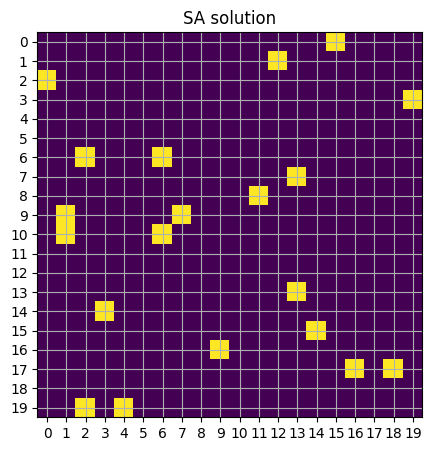

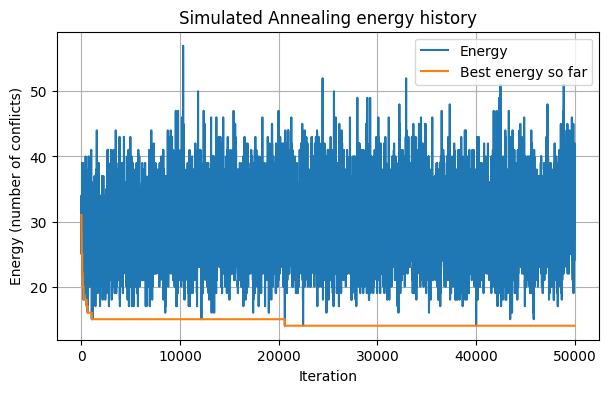


=== Running Genetic Algorithm ===
Genetic Algorithm:
  Board size: 20x20, queens: 20
  Best energy (conflicts): 8
  Best fitness: 182
  Elapsed time: 36.5104 seconds
. . . . . . . . . . . Q . . . . Q . . .
. . . . . . . . . . . . . . . . . . . .
. . . . . Q . . . . . . . . . . . . . .
Q . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . Q
. . Q . . . . . . . . . . . . . . . . .
. . . Q . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . Q .
. . . . . . . . Q . . . . . . . . . . .
. . . . . . . . . . Q . . . . . . . . .
. . . . . . Q . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . Q . .
. Q . . . . . . . . . . . . Q . . . . .
. . . . . . . . . . . . . . . . . . Q .
. . . . . . . . . . . . . Q . . . . . .
. . . . . . . . . . . . . . . . . . . .
. . Q . . . . . . Q . . . . . . . . . .
. . . . Q . . . . . . . . . . . . . . .
. . . . . . . . . . . . Q . . . . . . .


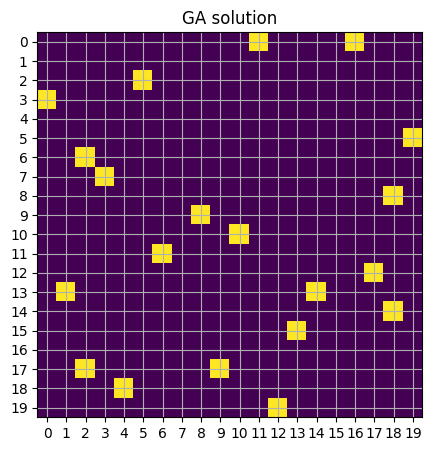

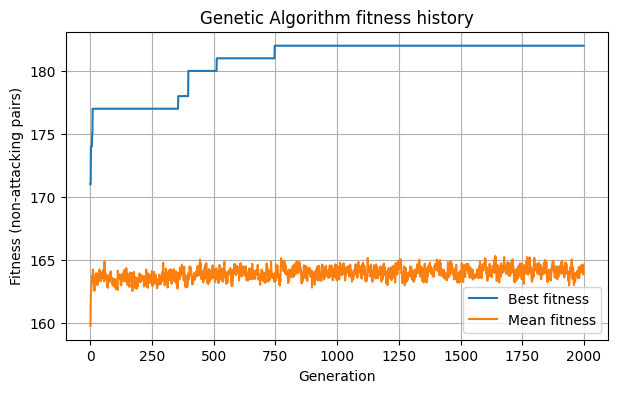


=== Comparison (single run) ===
SA: best_energy=14, time=5.2909s
GA: best_energy=8, time=36.5104s


In [10]:
compare_results_20 = compare_sa_and_ga(N=20, m=20, seed_sa=0, seed_ga=1)

#### Genaralized 8-Queens with both algorithms


=== Running Simulated Annealing ===
Simulated Annealing:
  Board size: 8x8, queens: 10
  Best energy (conflicts): 6
  Elapsed time: 1.5257 seconds
. . Q . . . Q .
. . . . Q . . .
. . . . . . . Q
. . . . Q . . .
Q . . . . . . .
. . . . . Q . .
. . . . . Q . .
. Q . . . . Q .


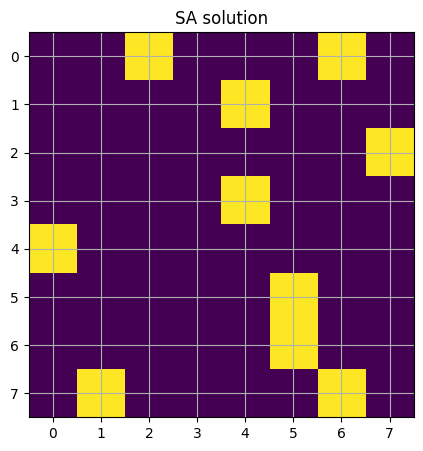

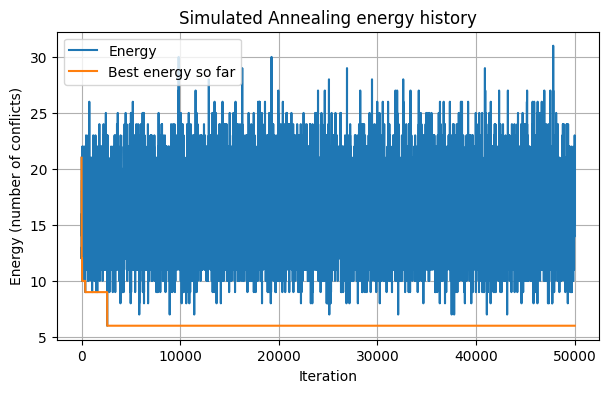


=== Running Genetic Algorithm ===
Genetic Algorithm:
  Board size: 8x8, queens: 10
  Best energy (conflicts): 5
  Best fitness: 40
  Elapsed time: 9.7044 seconds
. . . . . . Q .
Q . Q . . . . .
. . . . . Q . .
. . . . . . . Q
Q . . . . . . .
. . . Q . . . .
. . . . . . Q .
. Q . . Q . . .


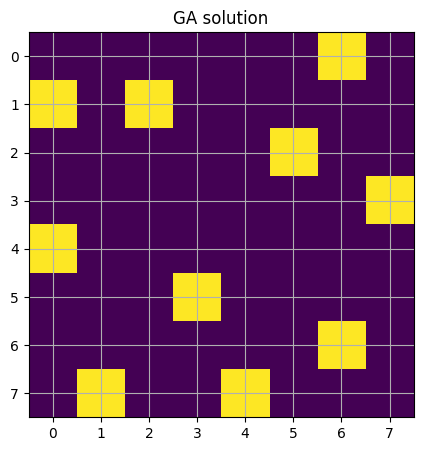

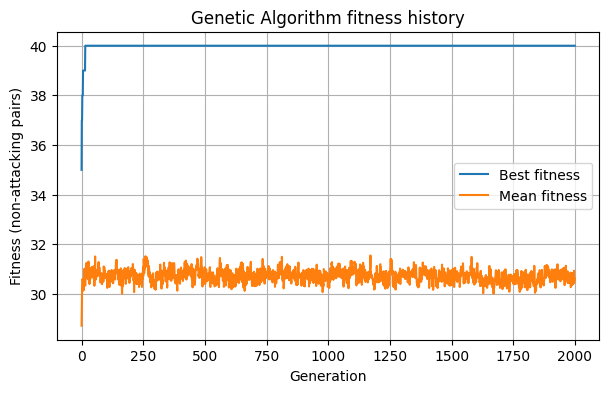


=== Comparison (single run) ===
SA: best_energy=6, time=1.5257s
GA: best_energy=5, time=9.7044s


In [11]:
compare_results_gen8_10 = compare_sa_and_ga(N=8, m=10, seed_sa=0, seed_ga=1)

## Results & Analysis

### 1. Which one is faster?

I defined a utility function `run_multiple_experiments` to execute a given solver (SA or GA) multiple times with different random seeds for a specified N-Queens problem. This function will collect the best energy and elapsed time from each run, serving as a reusable component for comparative analysis.

This function conducts multiple runs (e.g., 30) for both Simulated Annealing and Genetic Algorithm on a specific N-Queens problem (e.g., N=20, m=20). The code will then calculate and display statistical summaries (mean, standard deviation) of the 'best energy' and 'elapsed time' for each algorithm. Additionally, it generated visualizations, such as box plots of best energies, to illustrate the stability and optimality of solutions. A concluding statement will interpret these results to answer Question 2 about which algorithm provides more stable or optimal solutions.



In [ ]:
def run_multiple_experiments(
    solver_class,
    N: int,
    m: Optional[int],
    seeds: List[int],
    solver_params: Dict[str, Any],
) -> Dict[str, List[float]]:
    """
    Runs a given N-Queens solver multiple times with different seeds and collects results.

    Args:
        solver_class: The solver class (e.g., SimulatedAnnealingSolver, GeneticAlgorithmSolver).
        N: Board size.
        m: Number of queens.
        seeds: List of random seeds for each run.
        solver_params: Dictionary of parameters specific to the solver.

    Returns:
        A dictionary containing lists of 'best_energies' and 'elapsed_times'.
    """
    best_energies = []
    elapsed_times = []

    for seed in seeds:
        problem = NQueensProblem(board_size=N, num_queens=m, seed=seed)
        solver = solver_class(problem, seed=seed, **solver_params)
        result = solver.solve()

        best_energies.append(result["best_energy"])
        elapsed_times.append(result["elapsed_time"])

    return {"best_energies": best_energies, "elapsed_times": elapsed_times}

In [ ]:
N = 20
m = 20
runs = 30
seeds = list(range(runs))

sa_solver_params = {
    "T0": 10.0,
    "alpha": 0.995,
    "max_iterations": 50_000,
    "iterations_per_temp": 50,
    "reheating_factor": 1.5,
    "stagnation_window": 1_000,
}

ga_solver_params = {
    "population_size": 200,
    "crossover_rate": 0.9,
    "mutation_rate": 0.2,
    "max_generations": 2_000,
    "tournament_size": 3,
    "elitism": True,
}

In [ ]:
sa_results = run_multiple_experiments(
    solver_class=SimulatedAnnealingSolver,
    N=N,
    m=m,
    seeds=seeds,
    solver_params=sa_solver_params,
)

ga_results = run_multiple_experiments(
    solver_class=GeneticAlgorithmSolver,
    N=N,
    m=m,
    seeds=seeds,
    solver_params=ga_solver_params,
)

In [13]:
print("\n--- Simulated Annealing Results ---")
print(f"Best Energy - Mean: {np.mean(sa_results['best_energies']):.2f}, Std Dev: {np.std(sa_results['best_energies']):.2f}")
print(f"Elapsed Time - Mean: {np.mean(sa_results['elapsed_times']):.4f}s, Std Dev: {np.std(sa_results['elapsed_times']):.4f}s")

print("\n--- Genetic Algorithm Results ---")
print(f"Best Energy - Mean: {np.mean(ga_results['best_energies']):.2f}, Std Dev: {np.std(ga_results['best_energies']):.2f}")
print(f"Elapsed Time - Mean: {np.mean(ga_results['elapsed_times']):.4f}s, Std Dev: {np.std(ga_results['elapsed_times']):.4f}s")


--- Simulated Annealing Results ---
Best Energy - Mean: 7.77, Std Dev: 0.80
Elapsed Time - Mean: 1.6630s, Std Dev: 0.4335s

--- Genetic Algorithm Results ---
Best Energy - Mean: 3.50, Std Dev: 0.72
Elapsed Time - Mean: 16.2844s, Std Dev: 0.4192s


As the information above illustrates, Simulated Annealing reaches the desired solution in approximately one-tenth of the time required by the Genetic Algorithm. However, the GA is expected to terminate with a result that is roughly twice as good as the best solution obtained by SA, due to the GA’s higher exploration capability. The following plot effectively demonstrates this fact:

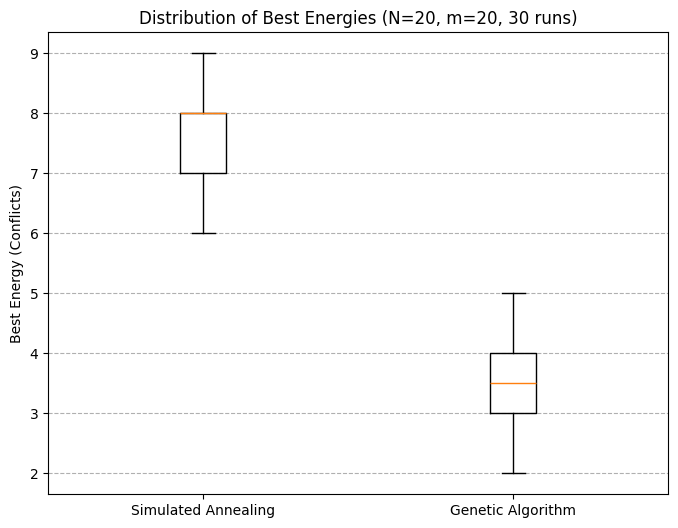

In [17]:
plt.figure(figsize=(8, 6))
plt.boxplot([sa_results['best_energies'], ga_results['best_energies']], tick_labels=['Simulated Annealing', 'Genetic Algorithm'])
plt.title('Distribution of Best Energies (N=20, m=20, 30 runs)')
plt.ylabel('Best Energy (Conflicts)')
plt.grid(axis='y', linestyle='--')
plt.show()

### 2. Interpretation of Results (Stability and Optimality)

For the N=20, m=20 N-Queens problem over 30 runs:

**Optimality (Best Energy):**
*   **Genetic Algorithm (GA)** consistently achieved lower average best energies (mean: 3.50 conflicts) compared to **Simulated Annealing (SA)** (mean: 7.77 conflicts). This suggests that GA is more effective at finding solutions with fewer conflicts, indicating better optimality.
*   The box plot visually reinforces this, with GA's box being significantly lower on the 'Best Energy' axis.

**Stability (Variability of Best Energy):**
*   **Genetic Algorithm (GA)** showed a standard deviation of 0.72 for best energies, while **Simulated Annealing (SA)** had a standard deviation of 0.80. Although both are relatively low, GA's slightly smaller standard deviation, combined with its lower mean, indicates slightly better consistency in finding optimal or near-optimal solutions.
*   The box plot confirms that GA's spread of best energies is narrower and centered closer to 0 conflicts, demonstrating greater stability in achieving good results across multiple runs.

**Performance (Elapsed Time):**
*   **Simulated Annealing (SA)** was significantly faster, with an average elapsed time of 1.6630 seconds (Std Dev: 0.4335s).
*   **Genetic Algorithm (GA)** took considerably longer, averaging 16.2844 seconds (Std Dev: 0.4192s).

**Conclusion:**
For the N=20, m=20 N-Queens problem with the given parameters, the **Genetic Algorithm (GA)** demonstrates superior **optimality** by consistently finding solutions with significantly fewer conflicts and slightly better **stability** (lower standard deviation of best energies). However, **Simulated Annealing (SA)** is considerably **faster**. If the primary goal is to find solutions with the absolute minimum number of conflicts, GA is the preferred choice, provided the increased computation time is acceptable. If speed is critical and a slightly higher conflict count is tolerable, SA performs better.

### 3. Algorithms' Pros & cons


#### Advantages and Disadvantages of Simulated Annealing

**Theoretical Advantages:**
*   **Ability to Escape Local Optima:** A key strength of SA is its ability to accept worse solutions with a certain probability—particularly at higher temperatures. This mechanism allows it to escape local optima, which is essential in complex, multimodal search landscapes.
*   **Conceptual Simplicity:** The algorithm is straightforward to understand and implement, involving a current state, a neighbor function, an energy function, and a temperature schedule.
*   **Generality:** SA can be applied to a wide range of optimization problems, provided an energy function and a way to generate neighboring states can be defined.

**Theoretical Disadvantages:**
*   **Parameter Tuning:** The performance of SA is highly dependent on the correct tuning of its parameters (initial temperature `T0`, cooling rate `alpha`, iterations per temperature, reheating factor, stagnation window). Poor parameter choices can lead to premature convergence to a local optimum or extremely slow search.
*   **No Memory of Past Searches:** SA is a single-point search algorithm; it only considers the current state and its neighbors. It doesn't explicitly 'learn' from previously visited good solutions (other than updating the `best_state` found so far).
*   **Computational Cost per Iteration:** Evaluating the energy of each new state might be computationally intensive for some problems.


#### Advantages and Disadvantages of Genetic Algorithms

**Theoretical Advantages:**
*   **Global Search Capability (Exploration):** GAs explore a large solution space concurrently by maintaining a population of solutions. This population-based approach makes them very effective at exploring different regions of the search space, reducing the risk of getting trapped in local optima.
*   **Robustness:** They are generally robust to noisy data and complex objective functions.
*   **Adaptability:** GAs are highly adaptable to different problem domains by simply changing the encoding of the solution and the fitness function.

**Theoretical Disadvantages:**
*   **Computational Cost:** Maintaining and evolving a population of solutions through selection, crossover, and mutation can be computationally expensive, especially for large populations or complex problems, leading to longer execution times per generation.
*   **Premature Convergence:** Despite their global search capabilities, GAs can sometimes converge prematurely to sub-optimal solutions, especially if selection pressure is too high or genetic diversity is lost too quickly.
*   **Parameter Tuning:** GAs have numerous parameters (population size, crossover rate, mutation rate, selection method, elitism) that significantly impact their performance. Optimal tuning can be challenging and problem-dependent.
*   **No Guarantee of Optimality:** While good at finding near-optimal solutions, GAs do not guarantee finding the absolute global optimum within a finite time. Their probabilistic nature means there's always a chance of missing the best solution. Moreover, it's possible that after only a few generations, all individuals may become nearly identical. Once this happens, the algorithm loses its ability to explore new areas of the search space, dramatically reducing the likelihood of discovering a better solution.
*   **Encoding Scheme:** The effectiveness of a GA is highly dependent on the choice of the genetic representation (encoding) for the problem. A poor encoding can lead to inefficient search.


###  4. Analyze Scalability over increasing board sizes (N = 10, 20, 30, 40)



In [ ]:
N_values = [10, 20, 30, 40, 50]
num_runs = 5

sa_avg_best_energies = []
sa_avg_elapsed_times = []
ga_avg_best_energies = []
ga_avg_elapsed_times = []

In [19]:
for N_val in N_values:
    print(f"\n--- Running experiments for N = {N_val} ---")
    current_seeds = list(range(num_runs))

    # Run SA experiments
    sa_res_current_N = run_multiple_experiments(
        solver_class=SimulatedAnnealingSolver,
        N=N_val,
        m=N_val,
        seeds=current_seeds,
        solver_params=sa_solver_params,
    )
    sa_avg_best_energies.append(np.mean(sa_res_current_N['best_energies']))
    sa_avg_elapsed_times.append(np.mean(sa_res_current_N['elapsed_times']))
    print(f"SA for N={N_val}: Avg Best Energy={sa_avg_best_energies[-1]:.2f}, Avg Time={sa_avg_elapsed_times[-1]:.4f}s")

    # Run GA experiments
    ga_res_current_N = run_multiple_experiments(
        solver_class=GeneticAlgorithmSolver,
        N=N_val,
        m=N_val,
        seeds=current_seeds,
        solver_params=ga_solver_params,
    )
    ga_avg_best_energies.append(np.mean(ga_res_current_N['best_energies']))
    ga_avg_elapsed_times.append(np.mean(ga_res_current_N['elapsed_times']))
    print(f"GA for N={N_val}: Avg Best Energy={ga_avg_best_energies[-1]:.2f}, Avg Time={ga_avg_elapsed_times[-1]:.4f}s")

print("Finished collecting scalability data.")


--- Running experiments for N = 10 ---
SA for N=10: Avg Best Energy=2.00, Avg Time=0.5267s
GA for N=10: Avg Best Energy=0.40, Avg Time=3.9322s

--- Running experiments for N = 20 ---
SA for N=20: Avg Best Energy=7.40, Avg Time=1.4723s
GA for N=20: Avg Best Energy=3.40, Avg Time=16.7541s

--- Running experiments for N = 30 ---
SA for N=30: Avg Best Energy=15.20, Avg Time=3.3293s
GA for N=30: Avg Best Energy=10.00, Avg Time=31.5835s

--- Running experiments for N = 40 ---
GA for N=40: Avg Best Energy=15.00, Avg Time=52.9567s

--- Running experiments for N = 50 ---
SA for N=50: Avg Best Energy=31.80, Avg Time=8.8529s
GA for N=50: Avg Best Energy=22.40, Avg Time=78.7992s
Finished collecting scalability data.


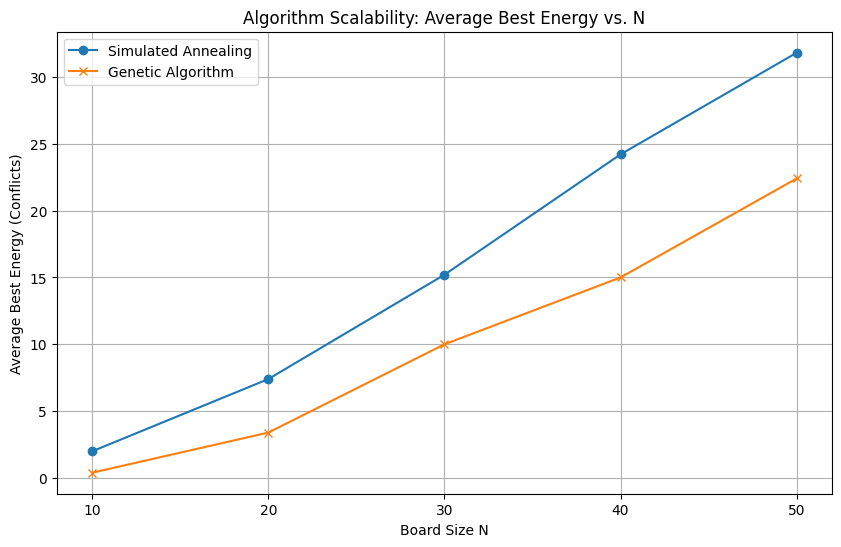

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(N_values, sa_avg_best_energies, marker='o', label='Simulated Annealing')
plt.plot(N_values, ga_avg_best_energies, marker='x', label='Genetic Algorithm')
plt.xlabel('Board Size N')
plt.ylabel('Average Best Energy (Conflicts)')
plt.title('Algorithm Scalability: Average Best Energy vs. N')
plt.legend()
plt.grid(True)
plt.xticks(N_values)
plt.show()

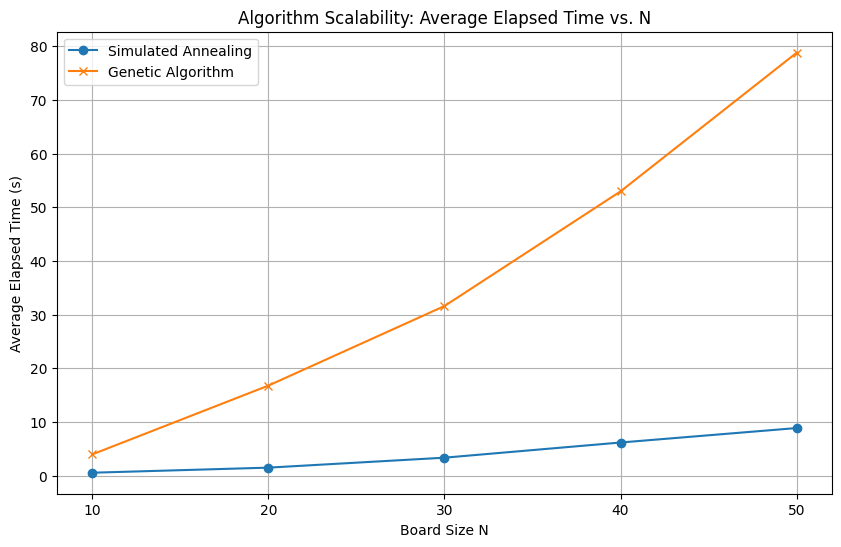

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(N_values, sa_avg_elapsed_times, marker='o', label='Simulated Annealing')
plt.plot(N_values, ga_avg_elapsed_times, marker='x', label='Genetic Algorithm')
plt.xlabel('Board Size N')
plt.ylabel('Average Elapsed Time (s)')
plt.title('Algorithm Scalability: Average Elapsed Time vs. N')
plt.legend()
plt.grid(True)
plt.xticks(N_values)
plt.show()

Based on the above plots:

**1. Scalability in terms of Optimality (Average Best Energy):**
*   **Genetic Algorithm:** Consistently achieved lower average best energies (fewer conflicts) than Simulated Annealing across all tested `N` values. While both algorithms show an increase in average conflicts as `N` grows, GA's curve for average best energy remains significantly below SA's.

*   **Simulated Annealing:** As the problem size grows, SA struggles more to find solutions with fewer conflicts, indicating poorer scalability in terms of optimality for larger boards with the given parameters.

**2. Scalability in terms of Performance (Average Elapsed Time):**
*   The plot exhibits a much steeper increase in elapsed time with increasing `N`. For N=50, GA takes considerably longer (approx. 79 seconds) than SA (approx. 8.8 seconds). This high computational cost for larger `N` indicates that GA scales poorly in terms of execution time.


Therefore, the answer of scalability depends on the primary concern: solution quality (optimality) or computational efficiency (time).

*   If **optimality** is the main concern, **Genetic Algorithm demonstrates better scalability**.
*   If **computational efficiency** is the main concern, **Simulated Annealing demonstrates better scalability**.


### 5. How to combine SA and GA?

A hybrid approach is possible:
- Use GA to search globally
- Apply SA as a local refinement step to each offspring

This is known as a memetic algorithm, combining population-based and local search advantages.